In [1]:
# This model was made using a docker image
# Docker image can be found at https://hub.docker.com/r/blackboxradiology/tf-2.6_with_pytorch
# docker pull blackboxradiology/tf-2.6_with_pytorch

# python version 3.6.9
# mayplotlib version 3.3.4
# numpy version 1.19.5
# pandas version 1.1.5
# PIL version 8.2.0
# sklearn version 0.24.2
# tensorflow version 2.6.0

from datetime import datetime
import glob
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from PIL import Image
import random as python_random
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import sys
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# pip install image-classifiers==1.0.0b1
from classification_models.tfkeras import Classifiers
# More information about this package can be found at https://github.com/qubvel/classification_models

In [2]:
np.random.seed(2021)
python_random.seed(2021)
tf.random.set_seed(2021)

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

# All preprocessing steps of MIMIC .jpg images are included in this repository
# Image data preprocessing include resizing to 320x320
# and normalizing images with ImageNet mean and standard deviation values
# using resnet34, preprocess_input = Classifiers.get('resnet34') from the classification_models.tfkeras package

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [4]:
# metadata_df is mimic-cxr-2.0.0-metadata.csv from https://physionet.org/content/mimic-cxr-jpg/2.0.0/
metadata_df = pd.read_csv('mimic-cxr-2.0.0-metadata.csv')
metadata_df[:0]

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning


In [5]:
# demographic_df is the addmissions.csv from the "core" directory found at https://physionet.org/content/mimiciv/1.0/
demographic_df = pd.read_csv('admissions.csv')
demographic_df = demographic_df.drop_duplicates(subset='subject_id')
demographic_df[:0]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag


In [6]:
print("Number of images: " + str(len(metadata_df)))

Number of images: 377110


In [7]:
print("Number of patients: " + str(metadata_df.subject_id.nunique()))

Number of patients: 65379


In [8]:
demographic_df.ethnicity.value_counts()

WHITE                            159471
BLACK/AFRICAN AMERICAN            31190
ASIAN                             16526
UNKNOWN                           16464
OTHER                             15859
HISPANIC/LATINO                   13334
UNABLE TO OBTAIN                   3086
AMERICAN INDIAN/ALASKA NATIVE       948
Name: ethnicity, dtype: int64

In [9]:
# remove patients who have inconsistent documented race information
# credit to github.com/robintibor
ethnicity_df = demographic_df.loc[:,['subject_id', 'ethnicity']].drop_duplicates()

v = ethnicity_df.subject_id.value_counts()
subject_id_more_than_once = v.index[v.gt(1)]

ambiguous_ethnicity_df = ethnicity_df[ethnicity_df.subject_id.isin(subject_id_more_than_once)]
inconsistent_race = ambiguous_ethnicity_df.subject_id.unique()

grouped = ambiguous_ethnicity_df.groupby('subject_id')
grouped.aggregate(lambda x: "_".join(sorted(x))).ethnicity.value_counts()

OTHER_WHITE                                                   2489
UNKNOWN_WHITE                                                 1131
BLACK/AFRICAN AMERICAN_OTHER                                   560
UNABLE TO OBTAIN_WHITE                                         308
HISPANIC/LATINO_OTHER                                          307
HISPANIC/LATINO_WHITE                                          204
HISPANIC/LATINO_UNKNOWN                                        173
BLACK/AFRICAN AMERICAN_WHITE                                   168
BLACK/AFRICAN AMERICAN_UNKNOWN                                 156
OTHER_UNKNOWN                                                  130
BLACK/AFRICAN AMERICAN_HISPANIC/LATINO                         111
ASIAN_OTHER                                                     98
UNABLE TO OBTAIN_UNKNOWN                                        49
ASIAN_WHITE                                                     46
BLACK/AFRICAN AMERICAN_UNABLE TO OBTAIN                       

In [10]:
merge_df = pd.merge(metadata_df,demographic_df,on='subject_id')
merge_df = merge_df[~merge_df.subject_id.isin(inconsistent_race)]
merge_df = merge_df.rename(columns={"ethnicity": "race"})
merge_df = merge_df[merge_df.race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]
merge_df = merge_df[merge_df.ViewPosition.isin(['AP','PA'])]

In [11]:
print("Total images after inclusion/exclusion criteria: " + str(len(merge_df)))

Total images after inclusion/exclusion criteria: 183217


In [12]:
print("Total patients after inclusion/exclusion criteria: " + str(merge_df.subject_id.nunique()))

Total patients after inclusion/exclusion criteria: 43209


In [13]:
data_df = merge_df
data_df.insert(5, "split","none", True)
unique_sub_id = data_df.subject_id.unique()

train_percent, valid_percent, test_percent = 0.60, 0.10, 0.30

unique_sub_id = shuffle(unique_sub_id)
value1 = (round(len(unique_sub_id)*train_percent))
value2 = (round(len(unique_sub_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_sub_id)*test_percent))

In [14]:
print("Patients in training set: " + str(value1))

Patients in training set: 25925


In [15]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 4321


In [16]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 12963


In [17]:
data_df = shuffle(data_df)

train_sub_id = unique_sub_id[:value1]
validate_sub_id = unique_sub_id[value1:value3]
test_sub_id = unique_sub_id[value3:]

In [18]:
data_df.loc[data_df.subject_id.isin(train_sub_id), "split"]="train"
data_df.loc[data_df.subject_id.isin(validate_sub_id), "split"]="validate"
data_df.loc[data_df.subject_id.isin(test_sub_id), "split"]="test"

In [19]:
data_df.split.value_counts(normalize=True)

train       0.601314
test        0.298215
validate    0.100471
Name: split, dtype: float64

In [20]:
data_df.race.value_counts()

WHITE                     141873
BLACK/AFRICAN AMERICAN     34238
ASIAN                       7106
Name: race, dtype: int64

In [21]:
data_df.race.value_counts(normalize=True)

WHITE                     0.774344
BLACK/AFRICAN AMERICAN    0.186871
ASIAN                     0.038785
Name: race, dtype: float64

In [22]:
data_df.subject_id = data_df.subject_id.astype(str)
data_df.study_id = data_df.study_id.astype(str)
data_df = data_df.fillna(0)
data_df.insert(2, "path", "")
data_df.path = data_df.subject_id.str[0:2]
data_df.path = "p" + data_df.path
data_df.path = data_df.path + "/p" + data_df.subject_id + "/s" + data_df.study_id + "/" + data_df.dicom_id + ".jpg"

In [27]:
data_df = pd.read_csv('MIMIC_3-race_60-10-30_split_ver_c.csv')

In [28]:
train_df = data_df[data_df.split=="train"]
validation_df = data_df[data_df.split=="validate"]
test_df = data_df[data_df.split=="test"]

In [29]:
#False indicates no patient_id shared between groups

unique_train_id = train_df.subject_id.unique()
unique_validation_id = validation_df.subject_id.unique()
unique_test_id = test_df.subject_id.unique()
all_id = np.concatenate((unique_train_id, unique_validation_id, unique_test_id), axis=None)

def contains_duplicates(X):
    return len(np.unique(X)) != len(X)

contains_duplicates(all_id)

False

In [30]:
HEIGHT, WIDTH = 320, 320

arc_name = "MIMIC-" + str(HEIGHT) + "x" + str(WIDTH) + "_60-10-30-split-resnet-Float16_3-race_detection"

In [31]:
resnet34, preprocess_input = Classifiers.get('resnet34')

In [33]:
input_a = Input(shape=(HEIGHT, WIDTH, 3))
base_model = resnet34(input_tensor=input_a, include_top=False, input_shape=(HEIGHT,WIDTH,3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(3, name='dense_logits')(x)
output = Activation('softmax', dtype='float32', name='predictions')(x)
model = Model(inputs=[input_a], outputs=[output])

In [34]:
learning_rate = 1e-3
momentum_val=0.9
decay_val= 0.0
batch_s = 256 # may need to reduce batch size if OOM error occurs
train_batch_size = batch_s
test_batch_size = 256

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2, min_lr=1e-5, verbose=1)

adam_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay_val)
adam_opt = tf.keras.mixed_precision.LossScaleOptimizer(adam_opt)

model.compile(optimizer=adam_opt,
                loss=tf.losses.CategoricalCrossentropy(),
                metrics=[
                    tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
                    tf.keras.metrics.AUC(curve='PR', name='PR-AUC')
                ],
)

In [35]:
train_gen = ImageDataGenerator(
            rotation_range=15,
            fill_mode='constant',
            horizontal_flip=True,
            zoom_range=0.1,
            preprocessing_function=preprocess_input
            )

validate_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [36]:
train_batches = train_gen.flow_from_dataframe(train_df, directory="/path/to/directory/", x_col="path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=True,seed=2021,batch_size=train_batch_size, dtype='float32')
validate_batches = validate_gen.flow_from_dataframe(validation_df, directory="/path/to/directory/", x_col="path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=False,batch_size=test_batch_size, dtype='float32')        

Found 110171 validated image filenames belonging to 3 classes.
Found 18408 validated image filenames belonging to 3 classes.


In [37]:
train_epoch = math.ceil(len(train_df) / train_batch_size)
val_epoch = math.ceil(len(validation_df) / test_batch_size)

In [38]:
var_date = datetime.now().strftime("%Y%m%d-%H%M%S")
ES = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)
checkloss = ModelCheckpoint("../saved_models/racial_bias/trials/" + str(arc_name) + "_CXR_LR-" + str(learning_rate) + "_" + var_date+"_epoch_{epoch:03d}_val_loss_{val_loss:.5f}.hdf5", monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [39]:
model.fit(train_batches,
            validation_data=validate_batches,
            epochs=100,
            steps_per_epoch=int(train_epoch),
            validation_steps=int(val_epoch),
            workers=32,
            max_queue_size=50,
            shuffle=True,
            callbacks=[checkloss, reduce_lr, ES]
           )

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
431/431 [==============================] - 880s 2s/step - loss: 0.5086 - ROC-AUC: 0.9290 - PR-AUC: 0.8746 - val_loss: 0.6313 - val_ROC-AUC: 0.9353 - val_PR-AUC: 0.8921

Epoch 00001: val_loss improved from inf to 0.63132, saving model to ../saved_models/racial_bias/trials/MIMIC-320x320_60-10-30-split-resnet-Float16_3-race_detection_CXR_LR-0.001_20210921-190152_epoch_001_val_loss_0.63132.hdf5


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
431/431 [==============================] - 623s 1s/step - loss: 0.3337 - ROC-AUC: 0.9690 - PR-AUC: 0.9455 - val_loss: 0.7818 - val_ROC-AUC: 0.8585 - val_PR-AUC: 0.7487

Epoch 00002: val_loss did not improve from 0.63132
Epoch 3/100
431/431 [==============================] - 671s 1s/step - loss: 0.2824 - ROC-AUC: 0.9774 - PR-AUC: 0.9599 - val_loss: 0.4662 - val_ROC-AUC: 0.9437 - val_PR-AUC: 0.8988

Epoch 00003: val_loss improved from 0.63132 to 0.46624, saving model to ../saved_models/racial_bias/trials/MIMIC-320x320_60-10-30-split-resnet-Float16_3-race_detection_CXR_LR-0.001_20210921-190152_epoch_003_val_loss_0.46624.hdf5
Epoch 4/100
431/431 [==============================] - 635s 1s/step - loss: 0.2501 - ROC-AUC: 0.9819 - PR-AUC: 0.9675 - val_loss: 0.4150 - val_ROC-AUC: 0.9530 - val_PR-AUC: 0.9141

Epoch 00004: val_loss improved from 0.46624 to 0.41500, saving model to ../saved_models/racial_bias/trials/MIMIC-320x320_60-10-30-split-resnet-Float16_3-race_detection_CXR_LR-0.

In [40]:
test_df.race.value_counts(normalize=True)

WHITE                     0.776749
BLACK/AFRICAN AMERICAN    0.184231
ASIAN                     0.039020
Name: race, dtype: float64

In [41]:
test_batch_size = 256

In [42]:
test_batches = validate_gen.flow_from_dataframe(test_df, directory="/path/to/directory/", x_col="path", y_col="race", class_mode="categorical",target_size=(HEIGHT, WIDTH),shuffle=False,batch_size=test_batch_size, dtype='float32')        

Found 54638 validated image filenames belonging to 3 classes.


In [43]:
multilabel_predict_test = model.predict(test_batches, max_queue_size=10, verbose=1, steps=math.ceil(len(test_df)/test_batch_size), workers=32)

214/214 [==============================] - 404s 2s/step


In [44]:
input_prediction = multilabel_predict_test
input_df = test_df
input_prediction_df = pd.DataFrame(input_prediction)
true_logits = pd.DataFrame()
loss_log = pd.DataFrame()

In [45]:
def stat_calc(input_prediction_df, input_df):
    ground_truth = input_df.race
    pathology_array=[
        'ASIAN',
        'BLACK/AFRICAN AMERICAN',
        'WHITE'
        ]
    i=0
    auc_array = []
    for pathology in pathology_array:
    
        new_truth = (ground_truth.str.contains(pathology)).apply(int)
        input_prediction_val = input_prediction_df[i]
        val = input_prediction_val
        AUC = roc_auc_score(new_truth, val)
        true_logits.insert(i, i, new_truth, True)
        auc_array.append(AUC)
        i += 1
        
    progress_df = pd.DataFrame({'Study':pathology_array, 'AUC':auc_array})
    print(progress_df)

In [46]:
stat_calc(input_prediction_df, input_df)

                    Study       AUC
0                   ASIAN  0.972251
1  BLACK/AFRICAN AMERICAN  0.982361
2                   WHITE  0.976957


Classwise ROC AUC 

Class - Asian ROC-AUC- 0.97
Class - Black ROC-AUC- 0.98
Class - White ROC-AUC- 0.98
              precision    recall  f1-score   support

       Asian       0.87      0.68      0.76      2132
       Black       0.94      0.84      0.88     10066
       White       0.95      0.99      0.97     42440

    accuracy                           0.95     54638
   macro avg       0.92      0.83      0.87     54638
weighted avg       0.95      0.95      0.94     54638



<AxesSubplot:>

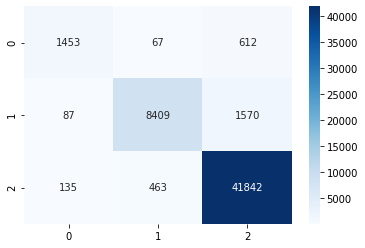

In [48]:
result = multilabel_predict_test
#result = model.predict(validate_batches, val_epoch)
labels = np.argmax(result, axis=1)
target_names = ['Asian', 'Black', 'White']

print ('Classwise ROC AUC \n')
for p in list(set(labels)):
    fpr, tpr, thresholds = roc_curve(test_batches.classes, result[:,p], pos_label = p)
    auroc = round(auc(fpr, tpr), 2)
    print ('Class - {} ROC-AUC- {}'.format(target_names[p], auroc))

print (classification_report(test_batches.classes, labels, target_names=target_names))
class_matrix = confusion_matrix(test_batches.classes, labels)

sns.heatmap(class_matrix, annot=True, fmt='d', cmap='Blues')